In [2]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling2D , GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D
from keras.layers import ConvLSTM2D, Bidirectional, CuDNNLSTM, LSTM

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
# %%time 

train_df = pickle.load( open("cache/train_df_64x128_aug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_64x128.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_64x128.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_64x128_aug.pik","rb"))
# test_df =  pickle.load(open("cache/test_df_256.pik","rb"))

In [4]:
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)
unknown_df.reset_index(inplace=True,drop=True)
silent_df.reset_index(inplace=True,drop=True)

In [5]:
test_preds = np.load("cache/predictions_conv2dlstm_plus_longblend1.npy")

In [5]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*2)],axis=0 )
        
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
#                 print this_train.loc[i,'raw'].T.shape
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [40]:
%time t = next(train_generator(4))[0][0].T

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 60.4 ms


In [42]:
t.shape

(128, 64)

In [6]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [48]:
%time next(valid_generator(4))[0].shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.24 ms


(4, 64, 128)

### forcing test predictions (hard - not soft)

In [32]:
to_categorical(name2id["unknown"],num_classes = len(POSSIBLE_LABELS))[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [8]:
test_preds[np.where(test_preds.max(axis=1)<0.5)[0]] = to_categorical(name2id["unknown"],num_classes = len(POSSIBLE_LABELS))[0]

test_preds = to_categorical(np.argmax(test_preds, axis=1),num_classes = len(POSSIBLE_LABELS))


In [48]:
# test_df["id"] = test_df.index.values

In [50]:
# test_df.reset_index(drop=True,inplace=True)

# test_df.drop(["level_0","index"],axis=1,inplace=True)

In [10]:
def test_pseudo_generator(test_batch_size):
    this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
    this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [42]:
next(test_pseudo_generator(14))[1].max()

1.0

In [11]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
#         print nexts[0][0].shape, nexts[1][0].shape
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [44]:
mi = MixIterator([train_generator(50), test_pseudo_generator(14)])


In [14]:
# next(mi)

In [31]:
valid_df.label_id.value_counts()

11    4221
1      270
3      264
0      261
2      260
9      260
10     257
6      257
7      256
5      256
4      247
8      246
Name: label_id, dtype: int64

### Model

In [4]:
def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [5]:
p = 0.

def get_conv_stacks( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    x =  Reshape((timesteps, input_dim,1))(x)
    
    
    
    x = Conv2D(64,(5,7),padding='same')(x) #was 32
    x = batch_relu(x)

    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)

    
    x = MaxPooling2D((1,3))(x)
    
    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(64,(3,3),padding='same')(x)
    x = batch_relu(x)

    
    
    x = MaxPooling2D((2,3))(x)
    

    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)

    x = MaxPooling2D((2,3))(x)
    
    
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
    x = Conv2D(128,(3,3),padding='same')(x)
    x = batch_relu(x)
    print int(x.shape[-1]) * int(x.shape[-2])
    x = Reshape((16,int(x.shape[-1]) * int(x.shape[-2])))(x)
    
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)



    
    return x

In [6]:
# p = 0.3

timesteps, input_dim , latent_dim = 64,128, 128

x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]

x = get_conv_stacks(x_logml)
# speaker_embedding = embedding(x_logml)


# x = concatenate([x,speaker_embedding])
x = Dense(128, activation = 'relu')(x) #
x = Dropout(0.3)(x)



x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




512


In [7]:

model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128)           512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 128, 64)       2304      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 128, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 64)       36928     
__________

In [102]:
# model.load_weights("weights/conv2d_wlstm_on_64x128.hdf5")

In [9]:
from keras.callbacks import TensorBoard
exp_name = "conv2d_wlstm_on_64x128_kernel5x7" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

soft pseudo:
Epoch 4/100
329/329 [==============================] - 105s 320ms/step - loss: 0.1513 - acc: 0.9739 - val_loss: 0.0916 - val_acc: 0.9724

soft pseudo - with val Epoch 10/10
329/329 [==============================] - 105s 320ms/step - loss: 0.1532 - acc: 0.9735 - val_loss: 0.0827 - val_acc: 0.9753


hard pseudo 
Epoch 4/100
329/329 [==============================] - 105s 321ms/step - loss: 0.0783 - acc: 0.9731 - val_loss: 0.0953 - val_acc: 0.9743


hard pseudo + val 
Epoch 10/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0637 - acc: 0.9801 - val_loss: 0.0532 - val_acc: 0.9850

In [127]:
batch_size = 64

# loss: 1.2527 -
history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 196s 596ms/step - loss: 0.9875 - acc: 0.6661 - val_loss: 0.5130 - val_acc: 0.8190
Epoch 2/100
329/329 [==============================] - 183s 555ms/step - loss: 0.4626 - acc: 0.8576 - val_loss: 0.3971 - val_acc: 0.8834
Epoch 3/100
329/329 [==============================] - 182s 552ms/step - loss: 0.3699 - acc: 0.8850 - val_loss: 0.5469 - val_acc: 0.8304
Epoch 4/100
329/329 [==============================] - 184s 559ms/step - loss: 0.3235 - acc: 0.9006 - val_loss: 0.3101 - val_acc: 0.9075
Epoch 5/100
329/329 [==============================] - 182s 553ms/step - loss: 0.2828 - acc: 0.9117 - val_loss: 0.2642 - val_acc: 0.9176
Epoch 6/100
329/329 [==============================] - 183s 555ms/step - loss: 0.2604 - acc: 0.9180 - val_loss: 0.1968 - val_acc: 0.9419
Epoch 7/100
329/329 [==============================] - 183s 555ms/step - loss: 0.2463 - acc: 0.9237 - val_loss: 0.2688 - val_acc: 0.9145
Epoch 8/100
329/329 [====================

In [217]:
exp_name

'conv2d_wlstm_on_64x128_kernel5x7'

In [10]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [19]:
mi = MixIterator([train_generator(45), valid_generator(5),test_pseudo_generator(14)])


In [20]:
from keras.callbacks import TensorBoard
exp_name = "conv2d_wlstm_hardpseudo_withval_c2" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [21]:
batch_size = 64

history = model.fit_generator(generator=mi,#train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 111s 337ms/step - loss: 0.0670 - acc: 0.9776 - val_loss: 0.0788 - val_acc: 0.9788
Epoch 2/100
329/329 [==============================] - 107s 325ms/step - loss: 0.0683 - acc: 0.9777 - val_loss: 0.0769 - val_acc: 0.9795
Epoch 3/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0730 - acc: 0.9762 - val_loss: 0.0715 - val_acc: 0.9808
Epoch 4/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0726 - acc: 0.9767 - val_loss: 0.0641 - val_acc: 0.9813
Epoch 5/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0648 - acc: 0.9785 - val_loss: 0.0641 - val_acc: 0.9823
Epoch 6/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0648 - acc: 0.9786 - val_loss: 0.0648 - val_acc: 0.9820
Epoch 7/100
329/329 [==============================] - 106s 323ms/step - loss: 0.0635 - acc: 0.9787 - val_loss: 0.0632 - val_acc: 0.9827
Epoch 8/100
328/329 [====================

KeyboardInterrupt: 

In [34]:
model.load_weights('./weights/conv2d_wlstm_hardpseudo_withval_c2.hdf5')

### valid evaluation

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [12]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

NameError: name 'valid_generator' is not defined

In [13]:
val_preds.shape

NameError: name 'val_preds' is not defined

In [219]:
oe = OneHotEncoder()

In [220]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [221]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [222]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.93      0.94      0.94       270
         up       0.89      0.95      0.92       260
       down       0.95      0.98      0.97       264
       left       0.95      0.98      0.96       247
      right       0.91      0.99      0.95       256
         on       0.95      0.95      0.95       257
        off       0.93      0.95      0.94       256
       stop       0.96      0.97      0.96       246
         go       0.91      0.92      0.92       260
    silence       0.94      1.00      0.97       257
    unknown       0.99      0.97      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.97      0.98       261
         no       0.97      0.98      0.97       270
         up       0.95      0.96      0.96       260
       down       0.99      0.98      0.98       264
       left       0.99      0.99      0.99       247
      right       0.99      0.98      0.99       256
         on       0.99      0.96      0.98       257
        off       0.97      0.96      0.96       256
       stop       0.98      0.97      0.98       246
         go       0.96      0.94      0.95       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.99      0.99      4221

avg / total       0.98      0.98      0.98      7055



In [29]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.97      0.98       261
         no       0.97      0.98      0.97       270
         up       0.95      0.96      0.96       260
       down       0.99      0.98      0.98       264
       left       0.99      0.99      0.99       247
      right       0.99      0.98      0.99       256
         on       0.99      0.96      0.98       257
        off       0.97      0.96      0.96       256
       stop       0.98      0.97      0.98       246
         go       0.96      0.94      0.95       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.99      0.99      4221

avg / total       0.98      0.98      0.98      7055



In [57]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.97      0.94       270
         up       0.92      0.95      0.93       260
       down       0.98      0.96      0.97       264
       left       0.97      0.99      0.98       247
      right       0.98      0.98      0.98       256
         on       0.95      0.95      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.96      0.96      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.98      0.99      4221

avg / total       0.98      0.98      0.98      7055



In [46]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.97      0.94       270
         up       0.92      0.94      0.93       260
       down       0.98      0.96      0.97       264
       left       0.97      0.99      0.98       247
      right       0.98      0.98      0.98       256
         on       0.95      0.95      0.95       257
        off       0.93      0.96      0.94       256
       stop       0.96      0.96      0.96       246
         go       0.93      0.92      0.92       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.98      0.99      4221

avg / total       0.97      0.97      0.97      7055



In [35]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.96      0.93       270
         up       0.92      0.94      0.93       260
       down       0.97      0.96      0.97       264
       left       0.97      0.99      0.98       247
      right       0.97      0.98      0.98       256
         on       0.94      0.95      0.94       257
        off       0.92      0.96      0.94       256
       stop       0.96      0.96      0.96       246
         go       0.92      0.92      0.92       260
    silence       0.95      1.00      0.98       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [21]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.91      0.95      0.93       270
         up       0.93      0.94      0.94       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.95      0.97      0.96       256
         on       0.95      0.95      0.95       257
        off       0.92      0.96      0.94       256
       stop       0.95      0.96      0.95       246
         go       0.92      0.92      0.92       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



#### tta test

In [23]:


def augment_wav(wav,pval=0.5):
    sample_rate = 16000
    L = 1000 #16000  # 1 sec
    
#     adjust speed, with 50% chance
    wav = speed_change(wav,1.+ random.choice([.08,-0.08])) #random.uniform(-1, 1)*0.05) if np.random.random() < pval else wav
    
    
    #adjust volume
#     db_adjustment = random.uniform(-1, 1)*10
    wav = wav + random.choice([-8,-3,7,11]) #randodb_adjustment if np.random.random() < pval else wav
     
        
    #fill to 1 second
    wav = fill_to_1sec(wav)        
        
    #shift the audio by 10 ms
    shift_length = 120
    if np.random.random() < 0.5: #shift to left
        wav = wav[:L-shift_length]+ AudioSegment.silent(shift_length,frame_rate=sample_rate)
    else: #shift to right
        wav = AudioSegment.silent(shift_length,frame_rate=sample_rate) + wav[shift_length:]
        
        
        
    #blend original file with background noise     
#     if np.random.random() < pval:
    noise = random.choice(silence_files_AS)
    db_delta = (wav.dBFS - noise.dBFS) - random.choice([8,9,10])

    if db_delta< 0: #reduce intensity of loud background; if it's too silent, leave it be
        noise = noise  + db_delta
    wav = wav.overlay(noise)
 
    return wav

def log_mel(samples,sample_rate=16000,reshape=False,n_mels=256):

		S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=n_mels,hop_length=252)

		# Convert to log scale (dB). We'll use the peak power (max) as reference.
		log_S = librosa.power_to_db(S, ref=np.max)
		log_S = log_S.reshape(log_S.shape[0],-1,1) if reshape else log_S

		return 	log_S
    
def process_wav_file(record, reshape=False, augment=False,pval=0.5 ,output_format='logmel',n_mels=128 ):
    
    if type(record) == str: # test files
        fname = record
        label = "test"
    else:    
        fname  = record.wav_file
        label = record.label

        
        
        
        
    if "raw_AS_wav" in record: 
        wav = record.raw_AS_wav
    else:
        wav = AudioSegment.from_wav(fname.replace("\\","/"))
        
        
    
    if (not label in ["silence"]) and augment: #no augmentation for sample files 
        wav = augment_wav(wav,pval)

    else: #make sure segment is 1 second
        wav = fill_to_1sec(wav)

        
    samples = AS_to_raw(wav)
    
    
    
    if output_format == "logmel":
        output = log_mel(samples,reshape=reshape,n_mels=n_mels)
        
    elif output_format == "mfcc":
        log_S = log_mel(samples,reshape=False,n_mels=n_mels)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=40) #hirese mfcc
        delta1 = librosa.feature.delta(mfcc, order=1)#hirese mfcc
        delta2 = librosa.feature.delta(mfcc, order=2)

        output = np.stack([mfcc,delta1,delta2])
        
    elif  output_format == "cqt":   
        samples = samples/samples
        output = librosa.cqt(samples, sr=16000 , fmin=librosa.note_to_hz('C2'),n_bins=60 * 2, bins_per_octave=12 * 2)
    else:
        output = samples
    
    
    return output


In [143]:
silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

filler = AudioSegment.silent(duration=1000, frame_rate = 16000)

def valid_generator_aug(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.loc[i],n_mels=256,augment=True).T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [31]:
augs= []
num_augs = 2
for i in range(num_augs):
    tmp_gen = valid_generator_aug(64)
    augs.append(model.predict_generator(tmp_gen,steps=int(np.ceil(valid_df.shape[0]/64.)),verbose=1))
    del tmp_gen

111/111 [==============================] - 77s 698ms/step


In [32]:
augs.append(val_preds)

In [33]:
val_blend = np.mean(augs,axis=0) #np.mean([val_preds,preds_aug1],axis=0)
val_blend = np.argmax(val_blend,axis=1)
val_blend = oe.transform(val_blend.reshape(-1, 1)).todense()

In [34]:
print classification_report(y_true,val_blend,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.90      0.94      0.92       270
         up       0.92      0.95      0.94       260
       down       0.94      0.96      0.95       264
       left       0.95      0.98      0.97       247
      right       0.94      0.98      0.96       256
         on       0.94      0.94      0.94       257
        off       0.92      0.96      0.94       256
       stop       0.95      0.96      0.95       246
         go       0.89      0.90      0.90       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.97      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [113]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.94      0.93       270
         up       0.89      0.93      0.91       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.96      0.97      0.97       256
         on       0.91      0.95      0.93       257
        off       0.92      0.95      0.93       256
       stop       0.97      0.95      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [63]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.91      0.94      0.92       270
         up       0.93      0.92      0.92       260
       down       0.93      0.97      0.95       264
       left       0.95      0.98      0.96       247
      right       0.95      0.95      0.95       256
         on       0.93      0.93      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.96      0.94      0.95       246
         go       0.90      0.91      0.90       260
    silence       0.99      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [32]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.97      0.95      0.96       264
       left       0.97      0.98      0.97       247
      right       0.97      0.94      0.96       256
         on       0.95      0.94      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.97      0.91      0.94       246
         go       0.88      0.87      0.87       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [176]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.93      0.92       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.96       264
       left       0.95      0.98      0.97       247
      right       0.97      0.95      0.96       256
         on       0.94      0.94      0.94       257
        off       0.90      0.95      0.92       256
       stop       0.96      0.94      0.95       246
         go       0.92      0.92      0.92       260
    silence       1.00      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [107]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.89      0.92      0.90       270
         up       0.92      0.94      0.93       260
       down       0.96      0.97      0.96       264
       left       0.96      0.98      0.97       247
      right       0.97      0.97      0.97       256
         on       0.93      0.95      0.94       257
        off       0.92      0.97      0.94       256
       stop       0.97      0.94      0.96       246
         go       0.91      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [78]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.88      0.91      0.89       270
         up       0.86      0.95      0.90       260
       down       0.92      0.95      0.93       264
       left       0.94      0.98      0.96       247
      right       0.94      0.95      0.95       256
         on       0.83      0.94      0.88       257
        off       0.87      0.94      0.90       256
       stop       0.98      0.93      0.95       246
         go       0.80      0.90      0.85       260
    silence       0.95      1.00      0.98       257
    unknown       0.98      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.92      0.92       270
         up       0.93      0.93      0.93       260
       down       0.99      0.95      0.97       264
       left       0.98      0.97      0.97       247
      right       0.99      0.95      0.97       256
         on       0.97      0.92      0.95       257
        off       0.94      0.92      0.93       256
       stop       0.99      0.94      0.97       246
         go       0.95      0.88      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.76      0.98      0.86       257

avg / total       0.95      0.94      0.94      3091



In [95]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.92      0.94      0.93       270
         up       0.92      0.93      0.93       260
       down       0.98      0.94      0.96       264
       left       0.97      0.97      0.97       247
      right       0.95      0.96      0.96       256
         on       0.96      0.95      0.96       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.94      0.97       246
         go       0.96      0.89      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.95      0.88       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



In [197]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.91      0.94      0.93       270
         up       0.90      0.95      0.92       260
       down       0.99      0.94      0.96       264
       left       0.98      0.98      0.98       247
      right       0.98      0.96      0.97       256
         on       0.98      0.93      0.95       257
        off       0.93      0.93      0.93       256
       stop       0.96      0.93      0.95       246
         go       0.95      0.90      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.94      0.87       257

avg / total       0.95      0.95      0.95      3091



### submission


In [14]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [15]:
len(test_paths)

158538

In [16]:
test_df = pickle.load( open("cache/test_df_256.pik","rb"))


In [21]:
test_df.shape

(158538, 5)

In [20]:
test_df.head()

,label,label_id,user_id,wav_file,raw
0,test,-1,test,./data/test/audio/clip_bd6d0fb25.wav,"[[-57.23230735388297, -62.82512929531555, -75...."
1,test,-1,test,./data/test/audio/clip_3e7a56353.wav,"[[-58.41587583033354, -52.501135617769904, -53..."
2,test,-1,test,./data/test/audio/clip_c5884a6cb.wav,"[[-73.8001558488084, -76.3301942530376, -72.38..."
3,test,-1,test,./data/test/audio/clip_ebf0d1f7b.wav,"[[-71.74843060253932, -64.93480667523741, -62...."
4,test,-1,test,./data/test/audio/clip_2f714f052.wav,"[[-49.64340117461414, -49.90604863028198, -49...."


In [ ]:
process_wav_file()

In [239]:
scipy.special.logit(1-1e-4)

9.2102403669759596

In [24]:
batch_size = 64 

def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
#                 x_batch.append(test_df.loc[i,'raw'].T)
                x_batch.append(process_wav_file(test_df.wav_file.iloc[i]).T)
            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [25]:
predictions = model.predict_generator(test_generator(batch_size), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 1800s 726ms/step


In [48]:
exp_name

'conv2d_wlstm_on_64x128_kernel5x7'

In [28]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [29]:
predictions = np.load("cache/predictions_{}.npy".format(exp_name))
predictions2 = np.load("cache/predictions_conv2d_wlstm.npy")
best_blend = np.load("cache/predictions_conv2dlstm_plus_longblend1.npy")
conv1d_ens = np.load("cache/predictions_frqmaxpool256_plus_longblend1.npy")

In [36]:
import seaborn as sns
import scipy
np.clip()

<function numpy.core.fromnumeric.clip>

In [41]:
df3 = pd.DataFrame(scipy.special.logit(np.clip(np.vstack([predictions.flatten(),
                              predictions2.flatten(),best_blend.flatten(),conv1d_ens.flatten()]).T,1e-5, 1-1e-5)),
                  columns=['crnn-128','crnn-256','best_blend',"conv1d_ens"])

In [42]:
df3.corr()

,crnn-128,crnn-256,best_blend,conv1d_ens
crnn-128,1.000000,0.953800,0.902371,0.869422
crnn-256,0.953800,1.000000,0.906422,0.862899
best_blend,0.902371,0.906422,1.000000,0.991288
conv1d_ens,0.869422,0.862899,0.991288,1.000000


(array([12144.,  6507.,  5787.,  6699.,  6250.,  6764.,  6711.,  5945.,
         6266., 95465.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

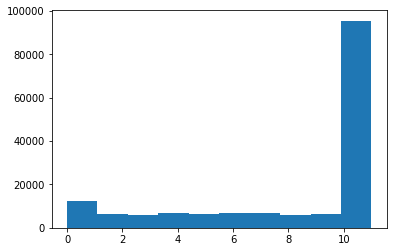

In [43]:
plt.hist(np.argmax(predictions,axis=1))

In [47]:
(np.argmax(predictions,axis=1) == np.argmax(scipy.special.logit(predictions),axis=1)).sum()

158538

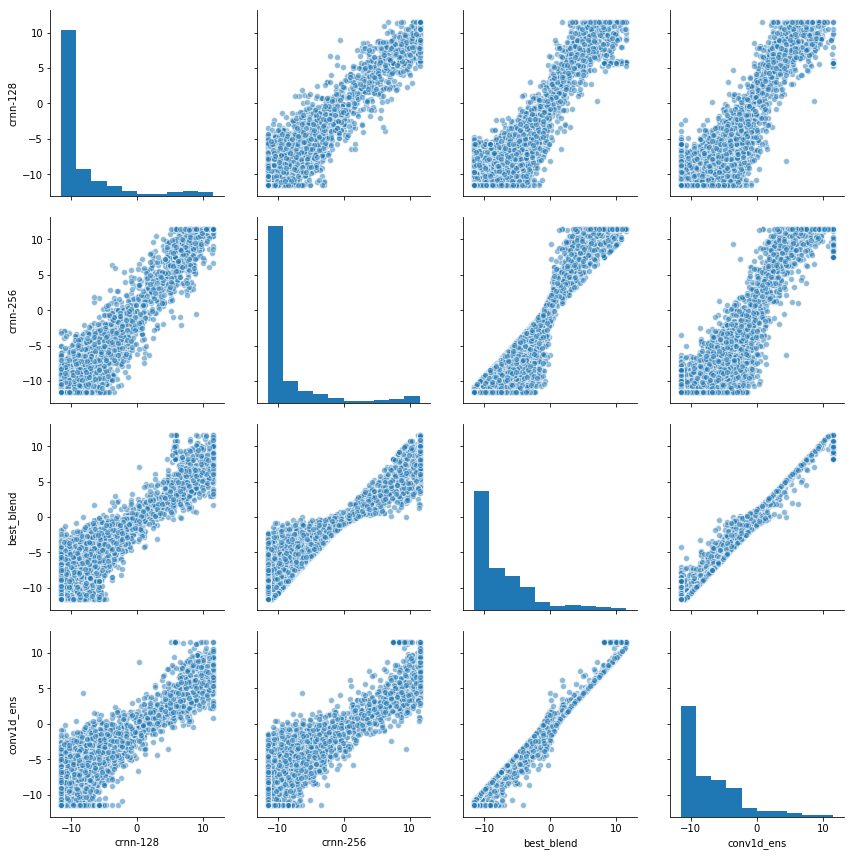

In [44]:
import seaborn as sns 
sns.pairplot(df3.sample(10000),plot_kws={'alpha':.5},size=3)

In [ ]:
tta_preds = []
num_aug = 4
for i in range(num_aug):
    tta_preds.append(model.predict_generator(test_generator(batch_size,augment=True), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1))

2476/2478 [============================>.] - ETA: 1s

In [ ]:
# import pickle

# pickle.dump(tta_preds,open("cache/test_preds_aug_4x.pik",'wb'),pickle.HIGHEST_PROTOCOL)

# tta_preds = pickle.load(open("cache/test_preds_aug_4x.pik",'rb'))

# tta_preds.append(predictions)

In [8]:
predictions = np.mean(tta_preds,axis=0)

In [9]:
predictions.shape

(158538, 12)

#### blending

In [53]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
# blend1 = np.load('cache/predictions_blend_dilated_conv1d_timek123_n_freqk48_pseudo_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")
blend2 = np.load('cache/predictions_frqmaxpool256_plus_longblend1.npy')

In [54]:
blend3 = np.mean([predictions,
                       blend2], axis=0)


In [55]:
np.save("cache/predictions_{}_{}.npy".format(exp_name,"plus_blend2"),blend3)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [56]:
classes = np.argmax(blend3, axis=1)

(array([  11595.,    5486.,    5235.,    5880.,    5344.,    5915.,
           6014.,    5536.,    5239.,  102294.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

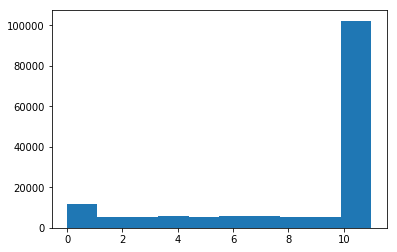

In [57]:
plt.hist(classes,bins=10)

(array([  11493.,    5413.,    5266.,    5854.,    5354.,    5840.,
           5999.,    5560.,    5174.,  102585.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

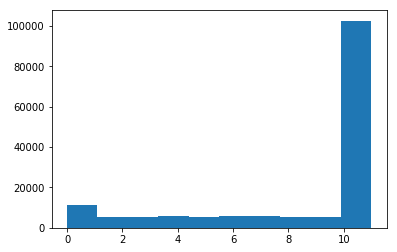

In [46]:
plt.hist(classes,bins=10)

(array([ 12543.,   6661.,   5327.,   6491.,   5741.,   6487.,   7599.,
          5891.,   5620.,  96178.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

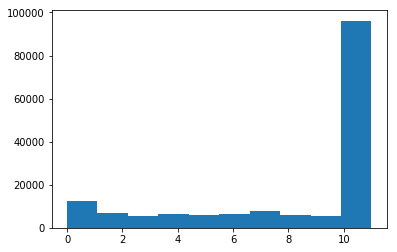

In [11]:
plt.hist(classes,bins=10)

(array([ 12300.,   6025.,   5316.,   6262.,   5586.,   6258.,   6430.,
          5676.,   5577.,  99108.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

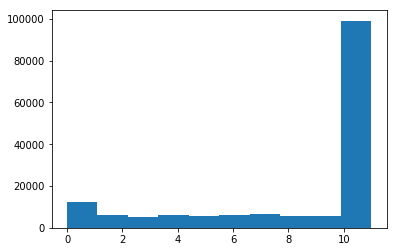

In [75]:
plt.hist(classes,bins=10)

### submission

In [58]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [59]:
with open('subm/{}_plus_blend2.csv'.format(exp_name), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [60]:
from IPython.lib.display import FileLink

FileLink('subm/{}_plus_blend2.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/conv2d_wlstm_hardpseudo_withval_c2_plus_blend2.csv

#### creae logits 


In [1]:
test_preds = np.load("cache/predictions_frqmaxpool256_plus_longblend1.npy")
# ("cache/predictions_conv2dlstm_plus_longblend1.npy") > best of 0.88

NameError: name 'np' is not defined

In [39]:
classes = np.argmax(test_preds, axis=1)

In [40]:
class_labels = []

for i in range(len(test_paths)):
    class_labels.append(id2name[classes[i]])
    


In [41]:
test_file_names = []
for i in range(len(test_paths)):
    test_file_names.append(os.path.basename(test_paths[i]))


In [42]:
test_file_names[0]

'clip_bd6d0fb25.wav'

In [28]:
test_preds[0]

array([  2.40163718e-04,   7.72146583e-01,   2.43576164e-06,
         1.97014995e-02,   4.51893255e-04,   3.37923157e-05,
         4.46151826e-05,   9.43910982e-06,   2.77688541e-05,
         8.60303640e-03,   1.87455362e-09,   1.98738813e-01], dtype=float32)

In [43]:
logits = pd.concat([pd.DataFrame(data=test_file_names,columns=["fname"]) ,
                    pd.DataFrame(data=class_labels,columns=["label"]), 
           pd.DataFrame(data = test_preds, columns=POSSIBLE_LABELS)],axis=1)

In [44]:
logits.tail()

,fname,label,yes,no,up,down,left,right,on,off,stop,go,silence,unknown
158533,clip_46e677bad.wav,off,1.213022e-08,1.026436e-08,0.000003,5.558455e-10,6.842185e-08,2.489757e-07,0.004123,0.995703,1.205144e-07,1.519155e-08,1.237315e-12,0.000170
158534,clip_13f4f3999.wav,off,1.239585e-07,1.203242e-07,0.000026,2.914093e-09,3.340961e-06,3.997619e-07,0.000219,0.999574,7.774687e-07,5.715653e-08,1.044358e-11,0.000177
158535,clip_74cb41418.wav,unknown,6.449070e-02,2.337105e-02,0.000352,8.286643e-03,9.265405e-03,4.419450e-03,0.000641,0.001358,3.103460e-04,1.224301e-02,1.957201e-05,0.875242
158536,clip_ffac8a06e.wav,on,2.791232e-07,3.442871e-07,0.000003,4.526026e-05,2.326786e-07,1.508896e-05,0.986539,0.000149,3.914220e-07,3.409091e-06,5.354774e-10,0.013244
158537,clip_c6798b35f.wav,no,1.660232e-03,8.252926e-01,0.000270,1.455574e-02,1.109665e-03,8.043834e-04,0.001901,0.000378,5.720982e-04,7.625429e-02,3.337102e-06,0.077198


In [45]:
logits.to_csv("cache/armin_logits_88.csv",index=False)